In [1]:
import torch

In [2]:
#assert torch.__version__.startswith('2.3') and 'cu121' in torch.__version__, "The Colab torch version has changed, you may need to edit the !pip install cell to install matching torch_geometric versions"

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

import rdkit
from rdkit.Chem import Descriptors
from rdkit.Chem import Lipinski
from rdkit import Chem
from rdkit.Chem import RDConfig
from rdkit.Chem import rdChemReactions
from rdkit.Chem import AllChem
from rdkit.Chem import Draw,BRICS,Recap
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdmolops
from rdkit.Chem.BRICS import BRICSDecompose
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols


from PIL import Image

import sys
import re
import tqdm
import os
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))

with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)
    import sascorer

In [5]:
df = pd.read_excel('D:\drug_modelling\Oxazolidinone.xlsx')
df.drop([0],inplace = True)
df.drop({'Unnamed: 0'},axis = 1, inplace = True)
df.rename({'Unnamed: 3':'MIC'},inplace=True,axis = 1)
df.dropna(inplace = True)
df['REWARD'] = 1/df['MIC']
df['PMIC']=np.log(df['MIC'])
df.reset_index(inplace = True,drop = True)
# df2.rename({'pMIC':'Reward'},axis = 1,inplace = True)

In [6]:
df.head(5)

,SMILE,Compound,MIC,REWARD,PMIC
0,NC1=CN=C(C=NN2CCN(C3=CC=C(N4C[C@H](CNC(C)=O)OC...,2a,10.00,0.1,2.302585
1,CC1=NC=C([N+]([O-])=O)N1CC=NN2CCN(C3=CC=C(N4C[...,2b,1.00,1.0,0.000000
2,CC1=NC=C([N+]([O-])=O)N1CC(C)=NN2CCN(C3=CC=C(N...,2c,1.00,1.0,0.000000
3,O=C(C)NC[C@H](OC1=O)CN1C(C=C2F)=CC=C2N3CCN(/N=...,2d,0.25,4.0,-1.386294
4,O=C(C)NC[C@H](OC1=O)CN1C(C=C2F)=CC=C2N3CCN(/N=...,2e,0.25,4.0,-1.386294


In [7]:
def number_atoms(mol):
  mol2 = mol
  for i, atom in enumerate(mol2.GetAtoms()):
      # For each atom, set the property "molAtomMapNumber" to a custom number, let's say, the index of the atom in the molecule
      atom.SetProp("molAtomMapNumber", str(atom.GetIdx()))

  return mol2

def AromaticAtoms(mol):
    aromatic_atoms = [mol.GetAtomWithIdx(i).GetIsAromatic() for i in range(mol.GetNumAtoms())]
    aa_count = []
    for i in aromatic_atoms:
      if i==True:
        aa_count.append(1)
    sum_aa_count = sum(aa_count)
    return sum_aa_count

def calc_descriptors(df):
  mols = [Chem.MolFromSmiles(smi) for smi in df['SMILE']]
  desc_MolLogP = [Descriptors.MolLogP(mol) for mol in mols]
  desc_MolWt = [Descriptors.MolWt(mol) for mol in mols]
  desc_NumRotatableBonds = [Descriptors.NumRotatableBonds(mol) for mol in mols]
  desc_AromaticAtoms = [AromaticAtoms(mol) for mol in mols]
  df['MolLogP'] = desc_MolLogP
  df['MolWt'] = desc_MolWt
  df['NumRotatableBonds'] = desc_NumRotatableBonds
  df['AromaticAtoms'] = desc_AromaticAtoms
  return df

#To test what samples are generated once before or after the training
def test_model(model = None,num_samples = 16, sub_img_size = 500,mols_per_row = 4):
  trajs = algo.create_training_data_from_own_samples(model,num_samples)
  gen_mols = []
  valid_trajs=[]
  for traj in trajs:
    try:
      mol = ctx.graph_to_obj(traj['result'])
      Chem.SanitizeMol(mol)  # Validate the molecule
      gen_mols.append(mol)
      valid_trajs.append(traj)
    except Chem.AtomValenceException:
      print(f"Valence issue in: {traj['result']}")
    except Chem.KekulizeException:
      print(f"Kekulization issue in: {traj['result']}")
    except Exception as e:
      print(f"Error: {e}")
  
  #gen_mols = [ctx.graph_to_obj(x['result']) for x in trajs]
  gen_mols_smiles = [Chem.MolToSmiles(mol) for mol in gen_mols]
  return gen_mols_smiles,gen_mols,Chem.Draw.MolsToGridImage(gen_mols, molsPerRow=mols_per_row, subImgSize=(sub_img_size, sub_img_size))

In [8]:
df = calc_descriptors(df)

In [9]:
display(df)

,SMILE,Compound,MIC,REWARD,PMIC,MolLogP,MolWt,NumRotatableBonds,AromaticAtoms
0,NC1=CN=C(C=NN2CCN(C3=CC=C(N4C[C@H](CNC(C)=O)OC...,2a,10.00,0.100000,2.302585,0.75880,458.498,6,11
1,CC1=NC=C([N+]([O-])=O)N1CC=NN2CCN(C3=CC=C(N4C[...,2b,1.00,1.000000,0.000000,1.50812,502.507,8,11
2,CC1=NC=C([N+]([O-])=O)N1CC(C)=NN2CCN(C3=CC=C(N...,2c,1.00,1.000000,0.000000,1.89822,516.534,8,11
3,O=C(C)NC[C@H](OC1=O)CN1C(C=C2F)=CC=C2N3CCN(/N=...,2d,0.25,4.000000,-1.386294,1.94430,474.449,7,11
4,O=C(C)NC[C@H](OC1=O)CN1C(C=C2F)=CC=C2N3CCN(/N=...,2e,0.25,4.000000,-1.386294,2.41280,490.517,7,11
...,...,...,...,...,...,...,...,...,...
228,S=C(NC1=CC=C(F)C=C1)NC2=CC=C(C[C@]3(C)NC(OC3)=...,53d,65.00,0.015385,4.174387,3.67560,359.426,4,12
229,S=C(NC1=CC=C(I)C=C1)NC2=CC=C(C[C@]3(C)NC(OC3)=...,53e,65.00,0.015385,4.174387,4.14110,467.332,4,12
230,S=C(NC1=CC=C(OC)C=C1)NC2=CC=C(C[C@]3(C)NC(OC3)...,53f,50.00,0.020000,3.912023,3.54510,371.462,5,12
231,S=C(NC1=CC=C(C)C=C1)NC2=CC=C(C[C@]3(C)NC(OC3)=...,53g,65.00,0.015385,4.174387,3.84492,355.463,4,12


In [10]:
def compute_properties(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return [None] * 11  

    mol_weight = Descriptors.MolWt(mol)
    logp = Descriptors.MolLogP(mol)
    tpsa = Descriptors.TPSA(mol)
    num_h_donors = Lipinski.NumHDonors(mol)
    num_h_acceptors = Lipinski.NumHAcceptors(mol)
    
    
    return [mol_weight, logp, tpsa, num_h_donors, num_h_acceptors]


df[['Molecular_Weight', 'LogP', 'TPSA', 'Num_H_Donors', 'Num_H_Acceptors']] = df['SMILE'].apply(compute_properties).apply(pd.Series)

In [11]:
display(df)

,SMILE,Compound,MIC,REWARD,PMIC,MolLogP,MolWt,NumRotatableBonds,AromaticAtoms,Molecular_Weight,LogP,TPSA,Num_H_Donors,Num_H_Acceptors
0,NC1=CN=C(C=NN2CCN(C3=CC=C(N4C[C@H](CNC(C)=O)OC...,2a,10.00,0.100000,2.302585,0.75880,458.498,6,11,458.498,0.75880,121.32,2.0,9.0
1,CC1=NC=C([N+]([O-])=O)N1CC=NN2CCN(C3=CC=C(N4C[...,2b,1.00,1.000000,0.000000,1.50812,502.507,8,11,502.507,1.50812,138.44,1.0,10.0
2,CC1=NC=C([N+]([O-])=O)N1CC(C)=NN2CCN(C3=CC=C(N...,2c,1.00,1.000000,0.000000,1.89822,516.534,8,11,516.534,1.89822,138.44,1.0,10.0
3,O=C(C)NC[C@H](OC1=O)CN1C(C=C2F)=CC=C2N3CCN(/N=...,2d,0.25,4.000000,-1.386294,1.94430,474.449,7,11,474.449,1.94430,133.76,1.0,9.0
4,O=C(C)NC[C@H](OC1=O)CN1C(C=C2F)=CC=C2N3CCN(/N=...,2e,0.25,4.000000,-1.386294,2.41280,490.517,7,11,490.517,2.41280,120.62,1.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228,S=C(NC1=CC=C(F)C=C1)NC2=CC=C(C[C@]3(C)NC(OC3)=...,53d,65.00,0.015385,4.174387,3.67560,359.426,4,12,359.426,3.67560,62.39,3.0,3.0
229,S=C(NC1=CC=C(I)C=C1)NC2=CC=C(C[C@]3(C)NC(OC3)=...,53e,65.00,0.015385,4.174387,4.14110,467.332,4,12,467.332,4.14110,62.39,3.0,3.0
230,S=C(NC1=CC=C(OC)C=C1)NC2=CC=C(C[C@]3(C)NC(OC3)...,53f,50.00,0.020000,3.912023,3.54510,371.462,5,12,371.462,3.54510,71.62,3.0,4.0
231,S=C(NC1=CC=C(C)C=C1)NC2=CC=C(C[C@]3(C)NC(OC3)=...,53g,65.00,0.015385,4.174387,3.84492,355.463,4,12,355.463,3.84492,62.39,3.0,3.0


testing models for proper mic prediction. 


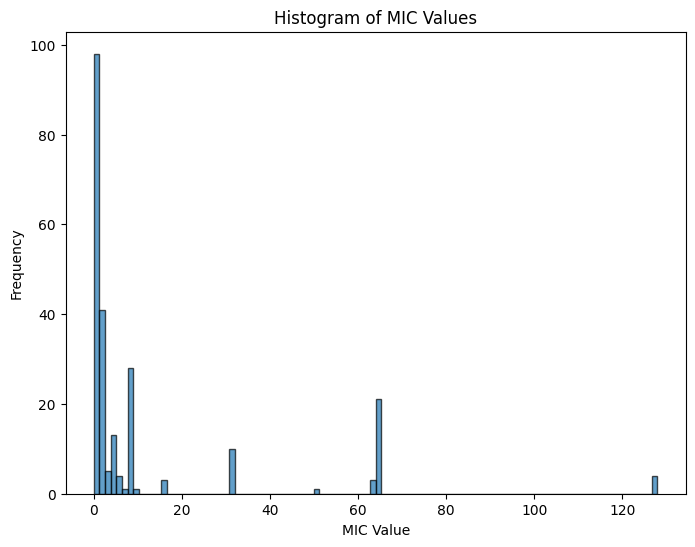

In [12]:
plt.figure(figsize=(8, 6)) 
plt.hist(df['MIC'], bins=100, edgecolor='black', alpha=0.7)

plt.xlabel('MIC Value')
plt.ylabel('Frequency')
plt.title('Histogram of MIC Values')

plt.show()

In [13]:
df_filtered = df[df['MIC'] < 40]
mic_mean = df_filtered['MIC'].mean()
print(f"Mean of 'mic': {mic_mean}")

mse = np.mean((df_filtered['MIC'] - mic_mean) ** 2)
print(f"Mean Squared Error (MSE): {mse}")

Mean of 'mic': 4.097852941176471
Mean Squared Error (MSE): 49.70064012543253


In [14]:
df = df_filtered

In [15]:
df['MOL'] = df['SMILE'].apply(Chem.MolFromSmiles)


fps = [FingerprintMols.FingerprintMol(mol, minPath=1, maxPath=7, fpSize=2048,
                                      bitsPerHash=2, useHs=True, tgtDensity=0.0, minSize=128)
       for mol in df['MOL']]

def calculate_mic_estimate(fp, fps, rewards):
    similarities = DataStructs.BulkTanimotoSimilarity(fp, fps)  
    mic_estimate = np.dot(np.array(similarities), np.array(rewards)) / len(similarities)  
    return mic_estimate


df['model1'] = [calculate_mic_estimate(fp, fps, df['MIC']) for fp in fps]


mse = np.mean((df['MIC'] - df['model1']) ** 2)

print("DataFrame with MIC estimates:")
display(df)
print(f"Mean Squared Error (MSE): {mse}")

DataFrame with MIC estimates:


,SMILE,Compound,MIC,REWARD,PMIC,MolLogP,MolWt,NumRotatableBonds,AromaticAtoms,Molecular_Weight,LogP,TPSA,Num_H_Donors,Num_H_Acceptors,MOL,model1
0,NC1=CN=C(C=NN2CCN(C3=CC=C(N4C[C@H](CNC(C)=O)OC...,2a,10.000,0.100000,2.302585,0.75880,458.498,6,11,458.498,0.75880,121.32,2.0,9.0,<rdkit.Chem.rdchem.Mol object at 0x00000267FFB...,2.134635
1,CC1=NC=C([N+]([O-])=O)N1CC=NN2CCN(C3=CC=C(N4C[...,2b,1.000,1.000000,0.000000,1.50812,502.507,8,11,502.507,1.50812,138.44,1.0,10.0,<rdkit.Chem.rdchem.Mol object at 0x00000267FFB...,2.154120
2,CC1=NC=C([N+]([O-])=O)N1CC(C)=NN2CCN(C3=CC=C(N...,2c,1.000,1.000000,0.000000,1.89822,516.534,8,11,516.534,1.89822,138.44,1.0,10.0,<rdkit.Chem.rdchem.Mol object at 0x00000267FFB...,2.163625
3,O=C(C)NC[C@H](OC1=O)CN1C(C=C2F)=CC=C2N3CCN(/N=...,2d,0.250,4.000000,-1.386294,1.94430,474.449,7,11,474.449,1.94430,133.76,1.0,9.0,<rdkit.Chem.rdchem.Mol object at 0x00000267FFB...,2.123263
4,O=C(C)NC[C@H](OC1=O)CN1C(C=C2F)=CC=C2N3CCN(/N=...,2e,0.250,4.000000,-1.386294,2.41280,490.517,7,11,490.517,2.41280,120.62,1.0,9.0,<rdkit.Chem.rdchem.Mol object at 0x00000267FFB...,2.094301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,O=C1O[C@@H](CNC(C)=O)[C@H]2N1CC3=CC(C4=CC=C(C#...,47a,0.125,8.000000,-2.079442,2.74598,379.391,3,12,379.391,2.74598,82.43,1.0,4.0,<rdkit.Chem.rdchem.Mol object at 0x00000267800...,1.914345
206,O=C1O[C@@H](CNC(C)=O)[C@H]2N1CC3=CC(N4CCOCC4)=...,47b,32.000,0.031250,3.465736,1.04390,363.389,3,6,363.389,1.04390,71.11,1.0,5.0,<rdkit.Chem.rdchem.Mol object at 0x00000267800...,2.023686
208,[H]/C(C1=CC=CC=C1)=N\C2=CC=C(CC(CO3)N(C4C(N(CC...,48,2.500,0.400000,0.916291,6.46940,536.459,8,18,536.459,6.46940,62.21,0.0,4.0,<rdkit.Chem.rdchem.Mol object at 0x00000267800...,1.882084
209,[H]/C(C1=CC=CC=C1)=N\C2=CC=C(CC(CO3)N(C4C(N(CC...,49,5.600,0.178571,1.722767,5.17980,527.621,10,18,527.621,5.17980,80.67,0.0,6.0,<rdkit.Chem.rdchem.Mol object at 0x00000267800...,1.917995


Mean Squared Error (MSE): 53.060350092445496


In [16]:
from rdkit.Chem import QED

df['QED'] = df['MOL'].apply(QED.qed)

print("DataFrame with QED values:")
display(df)

DataFrame with QED values:


,SMILE,Compound,MIC,REWARD,PMIC,MolLogP,MolWt,NumRotatableBonds,AromaticAtoms,Molecular_Weight,LogP,TPSA,Num_H_Donors,Num_H_Acceptors,MOL,model1,QED
0,NC1=CN=C(C=NN2CCN(C3=CC=C(N4C[C@H](CNC(C)=O)OC...,2a,10.000,0.100000,2.302585,0.75880,458.498,6,11,458.498,0.75880,121.32,2.0,9.0,<rdkit.Chem.rdchem.Mol object at 0x00000267FFB...,2.134635,0.613175
1,CC1=NC=C([N+]([O-])=O)N1CC=NN2CCN(C3=CC=C(N4C[...,2b,1.000,1.000000,0.000000,1.50812,502.507,8,11,502.507,1.50812,138.44,1.0,10.0,<rdkit.Chem.rdchem.Mol object at 0x00000267FFB...,2.154120,0.325669
2,CC1=NC=C([N+]([O-])=O)N1CC(C)=NN2CCN(C3=CC=C(N...,2c,1.000,1.000000,0.000000,1.89822,516.534,8,11,516.534,1.89822,138.44,1.0,10.0,<rdkit.Chem.rdchem.Mol object at 0x00000267FFB...,2.163625,0.318960
3,O=C(C)NC[C@H](OC1=O)CN1C(C=C2F)=CC=C2N3CCN(/N=...,2d,0.250,4.000000,-1.386294,1.94430,474.449,7,11,474.449,1.94430,133.76,1.0,9.0,<rdkit.Chem.rdchem.Mol object at 0x00000267FFB...,2.123263,0.365653
4,O=C(C)NC[C@H](OC1=O)CN1C(C=C2F)=CC=C2N3CCN(/N=...,2e,0.250,4.000000,-1.386294,2.41280,490.517,7,11,490.517,2.41280,120.62,1.0,9.0,<rdkit.Chem.rdchem.Mol object at 0x00000267FFB...,2.094301,0.359460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,O=C1O[C@@H](CNC(C)=O)[C@H]2N1CC3=CC(C4=CC=C(C#...,47a,0.125,8.000000,-2.079442,2.74598,379.391,3,12,379.391,2.74598,82.43,1.0,4.0,<rdkit.Chem.rdchem.Mol object at 0x00000267800...,1.914345,0.889026
206,O=C1O[C@@H](CNC(C)=O)[C@H]2N1CC3=CC(N4CCOCC4)=...,47b,32.000,0.031250,3.465736,1.04390,363.389,3,6,363.389,1.04390,71.11,1.0,5.0,<rdkit.Chem.rdchem.Mol object at 0x00000267800...,2.023686,0.869103
208,[H]/C(C1=CC=CC=C1)=N\C2=CC=C(CC(CO3)N(C4C(N(CC...,48,2.500,0.400000,0.916291,6.46940,536.459,8,18,536.459,6.46940,62.21,0.0,4.0,<rdkit.Chem.rdchem.Mol object at 0x00000267800...,1.882084,0.245004
209,[H]/C(C1=CC=CC=C1)=N\C2=CC=C(CC(CO3)N(C4C(N(CC...,49,5.600,0.178571,1.722767,5.17980,527.621,10,18,527.621,5.17980,80.67,0.0,6.0,<rdkit.Chem.rdchem.Mol object at 0x00000267800...,1.917995,0.268154


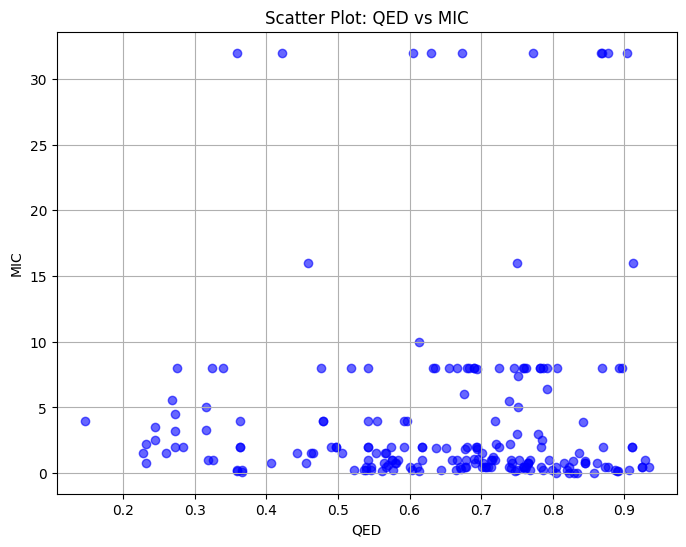

In [17]:
plt.figure(figsize=(8, 6))
plt.scatter(df['QED'], df['MIC'], alpha=0.6, color='b')
plt.title('Scatter Plot: QED vs MIC')
plt.xlabel('QED')
plt.ylabel('MIC')
plt.grid(True)
plt.show()

In [18]:
numeric_df = df.select_dtypes(include=['number'])

print(numeric_df.columns)

Index(['MIC', 'REWARD', 'PMIC', 'MolLogP', 'MolWt', 'NumRotatableBonds',
       'AromaticAtoms', 'Molecular_Weight', 'LogP', 'TPSA', 'Num_H_Donors',
       'Num_H_Acceptors', 'model1', 'QED'],
      dtype='object')


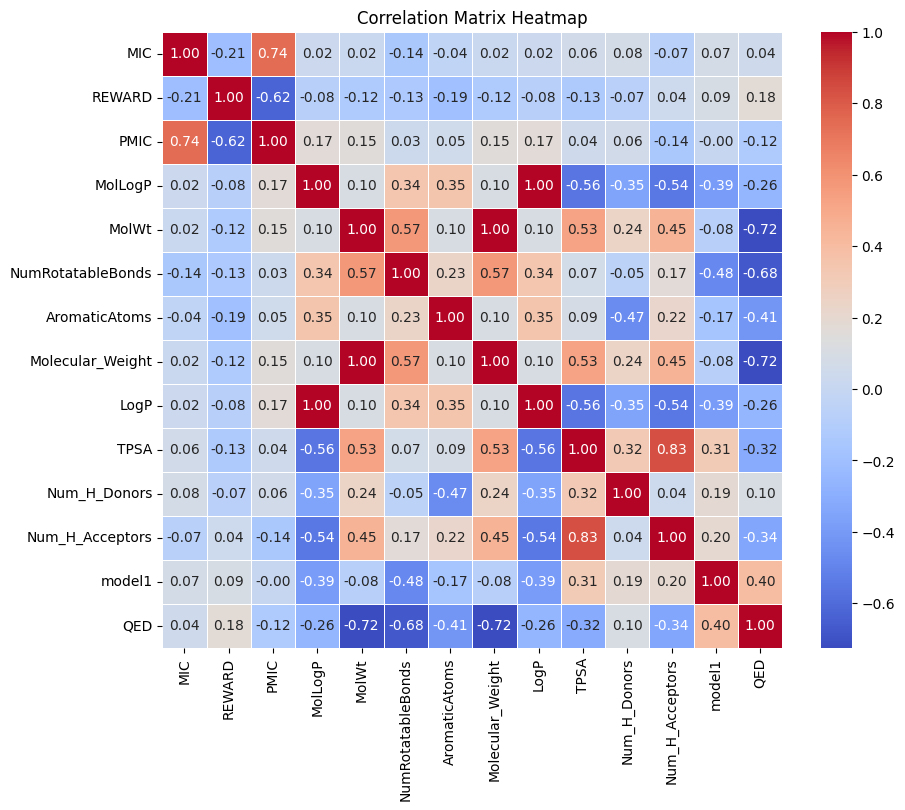

In [19]:
correlation_matrix = numeric_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [20]:
#sns.pairplot(numeric_df)
#plt.show()

In [21]:
X = df[['MolLogP', 'MolWt', 'NumRotatableBonds',
       'AromaticAtoms', 'Molecular_Weight', 'LogP', 'TPSA', 'Num_H_Donors',
       'Num_H_Acceptors', 'QED']] 
y = df['MIC']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

poly = PolynomialFeatures(degree=2)
X_poly_train = poly.fit_transform(X_train)
X_poly_test = poly.transform(X_test)

model = LinearRegression()
model.fit(X_poly_train, y_train)




LinearRegression()

In [22]:
predictions = model.predict(X_poly_train)
print(predictions)
mse = np.mean((y_train - predictions) ** 2)
print(f"Mean Squared Error: {mse}")

[ 1.19080544  1.65672684  0.48342609  6.77906895  7.8886261   7.40751457
  5.10544443  1.42184782  3.29659557 -3.83039951  3.57587957  1.40834618
 12.87105751  9.02570963 13.19864893  1.85887098  1.54009104 10.268291
  7.84939098 -2.50444365  3.56645441  7.3436594   8.4343648   0.7664957
  8.50612068  0.98159647  0.86542654  6.63152266 -1.06558847 -0.3707099
  7.597363    9.4916358   6.20430183  0.48342609  5.02979565 -3.64943314
  2.55077362  2.72009039  0.43364954 -0.45292807  6.20430183  2.64662361
  4.88373232 -2.00963116  4.88373184  4.10038614  1.10360956  7.68882608
 -0.33685064 -0.57012558  1.56004667  1.8755703  -0.54946756  2.58557081
  3.00881624  7.72860193  8.7956562   5.90329266  3.14774275 -2.5523777
  6.86938     5.65716934  1.75297451  6.42226553  5.46114349  3.2067914
  1.9801116  -1.71682739  4.90617943  4.366395    2.16725492  8.25193834
  6.53853989  4.12885094  4.31767654  7.40751457  2.63752794 -2.3058238
  4.15175581  5.0887475   3.92340326  0.49604082  8.902683

In [23]:

predictions = model.predict(X_poly_test)
print(predictions)
mse = np.mean((y_test - predictions) ** 2)
print(f"Mean Squared Error: {mse}")

[ 7.08450222e+00  9.79401541e+00  9.42354441e+00  3.20127773e+00
  6.05310249e+00  1.24233313e+01  3.75582647e+00 -5.24312830e+00
  2.70928144e+00  1.69968605e-01  2.22602606e+00 -1.13198328e+00
  1.19225402e+01  2.46047815e+02  1.10189652e+01 -1.42093086e+00
 -1.95192099e+00  3.20127773e+00  8.35105896e+00  4.41892815e+00
  1.35990477e+00 -2.61344147e+00  8.33357382e+00  1.65672684e+00
  3.00881624e+00 -1.95192099e+00  7.47745085e+00  8.78728533e+00
  2.02837276e+00  7.83933496e+00  3.98653936e+00  2.80143261e+00
  4.00468349e-01  1.30004549e+00  3.56645441e+00  4.31664896e+00
  2.21591282e+00  7.46685028e+00  8.46295118e+00  8.64972019e+00
  9.04216433e+00  5.20594120e+00  3.76446152e+00  1.62661791e+00
  3.25279236e-01  4.11833763e-01  8.49685049e+00  3.38973904e+00
 -4.63289499e+00  1.07854915e+01  3.23104572e+00  5.30878115e+00
  6.59047318e+00  2.20531368e+00 -3.34776402e+00  9.02570963e+00
 -2.77566147e+00  6.79919338e+00 -5.36921501e-01  2.99536562e+00
  7.58294010e+00  4.69390

In [24]:
for idx in range(30):
    print("Compound Number:",idx)
    mol2 = Chem.MolFromSmiles(df['SMILE'].iloc[idx])
    mol = Chem.MolFromSmiles(df['SMILE'].iloc[idx])
    Chem.Draw.MolsToGridImage([number_atoms(mol2)],subImgSize = (700,250),molsPerRow = 1)

Compound Number: 0
Compound Number: 1
Compound Number: 2
Compound Number: 3
Compound Number: 4
Compound Number: 5
Compound Number: 6
Compound Number: 7
Compound Number: 8
Compound Number: 9
Compound Number: 10
Compound Number: 11
Compound Number: 12
Compound Number: 13
Compound Number: 14
Compound Number: 15
Compound Number: 16
Compound Number: 17
Compound Number: 18
Compound Number: 19
Compound Number: 20
Compound Number: 21
Compound Number: 22
Compound Number: 23
Compound Number: 24
Compound Number: 25
Compound Number: 26
Compound Number: 27
Compound Number: 28
Compound Number: 29


In [25]:
df.head()

,SMILE,Compound,MIC,REWARD,PMIC,MolLogP,MolWt,NumRotatableBonds,AromaticAtoms,Molecular_Weight,LogP,TPSA,Num_H_Donors,Num_H_Acceptors,MOL,model1,QED
0,NC1=CN=C(C=NN2CCN(C3=CC=C(N4C[C@H](CNC(C)=O)OC...,2a,10.00,0.1,2.302585,0.75880,458.498,6,11,458.498,0.75880,121.32,2.0,9.0,<rdkit.Chem.rdchem.Mol object at 0x00000267FFB...,2.134635,0.613175
1,CC1=NC=C([N+]([O-])=O)N1CC=NN2CCN(C3=CC=C(N4C[...,2b,1.00,1.0,0.000000,1.50812,502.507,8,11,502.507,1.50812,138.44,1.0,10.0,<rdkit.Chem.rdchem.Mol object at 0x00000267FFB...,2.154120,0.325669
2,CC1=NC=C([N+]([O-])=O)N1CC(C)=NN2CCN(C3=CC=C(N...,2c,1.00,1.0,0.000000,1.89822,516.534,8,11,516.534,1.89822,138.44,1.0,10.0,<rdkit.Chem.rdchem.Mol object at 0x00000267FFB...,2.163625,0.318960
3,O=C(C)NC[C@H](OC1=O)CN1C(C=C2F)=CC=C2N3CCN(/N=...,2d,0.25,4.0,-1.386294,1.94430,474.449,7,11,474.449,1.94430,133.76,1.0,9.0,<rdkit.Chem.rdchem.Mol object at 0x00000267FFB...,2.123263,0.365653
4,O=C(C)NC[C@H](OC1=O)CN1C(C=C2F)=CC=C2N3CCN(/N=...,2e,0.25,4.0,-1.386294,2.41280,490.517,7,11,490.517,2.41280,120.62,1.0,9.0,<rdkit.Chem.rdchem.Mol object at 0x00000267FFB...,2.094301,0.359460


In [26]:
import chemprop
arguments = [
      '--test_path', '/dev/null',
      '--preds_path', '/dev/null',
      '--checkpoint_dir', 'chemprop_checkpoint'
  ]

args = chemprop.args.PredictArgs().parse_args(arguments)

model_objects = chemprop.train.load_model(args=args)

Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality


Loading training args
Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "readout.1.weight".
Loading pretrained parameter "readout.1.bias".
Loading pretrained parameter "readout.4.weight".
Loading pretrained parameter "readout.4.bias".


In [27]:
fps = [FingerprintMols.FingerprintMol(Chem.MolFromSmiles(x), minPath=1, maxPath=7, fpSize=2048,
                               bitsPerHash=2, useHs=True, tgtDensity=0.0,
                               minSize=128) for x in df['SMILE'][:30]]

def reward(mol):
  fp = FingerprintMols.FingerprintMol(mol, minPath=1, maxPath=7, fpSize=2048,
                               bitsPerHash=2, useHs=True, tgtDensity=0.0,
                               minSize=128)

  s = DataStructs.BulkTanimotoSimilarity(fp,fps)

  return (np.dot(np.array(s),np.array(df['REWARD'][:30]))/len(s))#*(np.exp(1/sascorer.calculateScore(mol)))

score_limit = 4.0
def reward_with_score(mol):
  #fp = FingerprintMols.FingerprintMol(mol, minPath=1, maxPath=7, fpSize=2048,
                               #bitsPerHash=2, useHs=True, tgtDensity=0.0,
                               #minSize=128)

  #s = DataStructs.BulkTanimotoSimilarity(fp,fps)
  smile = Chem.MolToSmiles(mol)
  
  smiles = [[smile]]
  preds = chemprop.train.make_predictions(args=args, smiles=smiles, model_objects=model_objects)
  prim_reward=preds[0][0]
  print("mic estimate",prim_reward)
  '''
  df = pd.DataFrame({'SMILES': [smile]})
  df.to_csv('input.csv', index=False)

  # Specify the path to the trained model
  model_path = 'chemprop_model_pca.pt'  # Update this path to your model file
  
  # Run chemprop predict using command line
  os.system(f"chemprop_predict --test_path input.csv --checkpoint_path {model_path} --preds_path chemprop_predictions.csv")

  # Read and display results
  if os.path.exists('chemprop_predictions.csv'):
      predictions = pd.read_csv('chemprop_predictions.csv') 
      print("\nResults:")
      print(predictions)
      print(predictions['pIC50'][0])
  else:
      print("Prediction failed to generate output file")
  mic_estimate = predictions['pIC50'][0]
  prim_reward = mic_estimate
  print("mic estimate",mic_estimate)'''
  sa_score = sascorer.calculateScore(mol)
  comp_pic50 = 80/prim_reward
  comp_sa = 20/sa_score
  prim_reward = comp_pic50 + comp_sa
  print("primary reward," , prim_reward)
  #print("sa_score," , sa_score)

  #wt = Descriptors.MolWt(mol)
  
  #temp = np.exp((-1*sa_score))*100                                #removed the score limit on the sa csore as it didnt make much sense
  #print("sa factor ," , temp)
  #prim_reward *= temp
  #sa_score = 1
  #print("primary reward wuth sa score," , prim_reward)
  # if(sa_score < score_limit):
  #   score_limit = sa_score
  #temp = np.exp((abs(wt - 600)*-1)/(100))*0.01                   #the weight factor was disproportionately changing the reward function,(on a magnitude of 62 orders!!) so scaled it appropriately. 
  #print("weigt factor," , temp)
  #prim_reward *= temp
  #print("primary reward with wweigt and sa sccroe," , prim_reward)
  #print("log reward", np.log(prim_reward))
  #print("_________________________________________________________________________________________________________________")
  return prim_reward, preds[0][0], sa_score
  # return (np.dot(np.array(s),np.array(df['REWARD'][:30]))/len(s))*(np.exp(1/sascorer.calculateScore(mol)))

changes since 25 oct   
1)removed the score limit on the sa csore as it didnt make much sense   
2)the weight factor was disproportionately changing the reward function,(on a magnitude of 62 orders!!) so scaled it appropriately.

In [28]:
import time

In [29]:
for i in range(5):
    start = time.time()
    print("molecule number, ", i)
    reward_with_score(Chem.MolFromSmiles(df['SMILE'].iloc[i]))
    end = time.time()
    print("time taken for prediction of one molecule",end-start)

molecule number,  0
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1


100%|██████████| 1/1 [00:04<00:00,  4.69s/it]


Saving predictions to /dev/null
Elapsed time = 0:00:05
mic estimate 6.029318973891103
primary reward, 18.86204181798289
time taken for prediction of one molecule 4.942193031311035
molecule number,  1
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1


100%|██████████| 1/1 [00:04<00:00,  4.45s/it]


Saving predictions to /dev/null
Elapsed time = 0:00:04
mic estimate 6.028618537070648
primary reward, 18.704912409132234
time taken for prediction of one molecule 4.451920747756958
molecule number,  2
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1


100%|██████████| 1/1 [00:04<00:00,  4.03s/it]


Saving predictions to /dev/null
Elapsed time = 0:00:04
mic estimate 6.024613562876716
primary reward, 18.71845755294333
time taken for prediction of one molecule 4.027164936065674
molecule number,  3
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1


100%|██████████| 1/1 [00:04<00:00,  4.01s/it]


Saving predictions to /dev/null
Elapsed time = 0:00:04
mic estimate 6.724208535445709
primary reward, 17.86631057871285
time taken for prediction of one molecule 4.021855592727661
molecule number,  4
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1


100%|██████████| 1/1 [00:04<00:00,  4.06s/it]

Saving predictions to /dev/null
Elapsed time = 0:00:04
mic estimate 6.634656682855656
primary reward, 17.934254498654976
time taken for prediction of one molecule 4.061272859573364


In [30]:
reward(Chem.MolFromSmiles(df['SMILE'].iloc[0]))

0.7337891258513708

In [31]:
final_frags = []
atch_idx = []
idx = -1

In [32]:
idx -= 1

Compound Number: -1


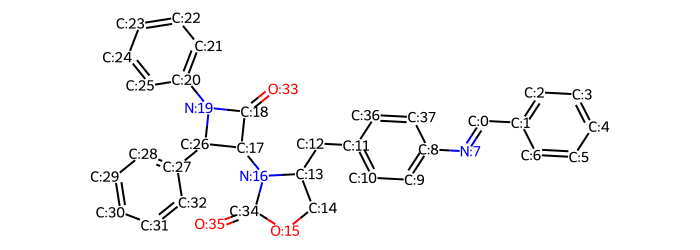

In [33]:
idx += 1
print("Compound Number:",idx)
mol2 = Chem.MolFromSmiles(df['SMILE'].iloc[idx])
mol = Chem.MolFromSmiles(df['SMILE'].iloc[idx])
Chem.Draw.MolsToGridImage([number_atoms(mol2)],subImgSize = (700,250),molsPerRow = 1)

In [34]:
break_idx = [(19,20)] #the indices about which fragmentation should take place

In [35]:
mh = Chem.RWMol(Chem.AddHs(mol))
for x in break_idx:
  a1idx = x[0]
  a2idx = x[1]
  Chem.Kekulize(mh,clearAromaticFlags=True)
  mh.RemoveBond(a1idx,a2idx) #Removing those respective bonds
  # print(Chem.MolToSmiles(mh))

In [36]:
#After the frags have been split, there is a '.' between each of their smiles representation
frags = [Chem.MolFromSmiles(x) for x in Chem.MolToSmiles(mh).split('.')]
curr_frags = []
for x in frags:
  sm = Chem.MolToSmiles(x)
  if(sm not in final_frags):
    final_frags.append(sm)
    curr_frags.append(sm)
  else:
    pass
    # frags.remove(x)
try:
  im = Chem.Draw.MolsToGridImage(list(map(lambda x:number_atoms(Chem.MolFromSmiles(x)),curr_frags)),molsPerRow = 3,subImgSize = (300,300))
except:
  im = None
  print("Nothing to add")

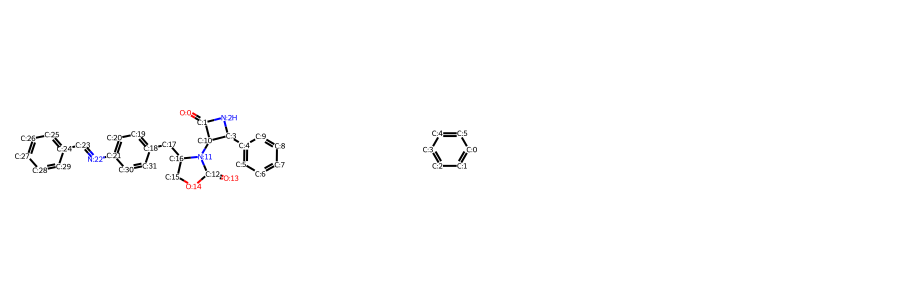

In [37]:
im

In [38]:
final_frags.pop(-1)

'c1ccccc1'

In [39]:
at_idx = [[5]]
for i in at_idx:
  atch_idx.append(i)
len(final_frags),len(atch_idx)

(1, 1)

In [40]:
'''valid_frags = [mol for mol in map(Chem.MolFromSmiles, final_frags) if mol is not None]

# Attempt to draw the valid molecules
from rdkit.Chem import Draw
img = Draw.MolsToGridImage(valid_frags, molsPerRow=3, subImgSize=(300, 300))
img.show()'''

'valid_frags = [mol for mol in map(Chem.MolFromSmiles, final_frags) if mol is not None]\n\n# Attempt to draw the valid molecules\nfrom rdkit.Chem import Draw\nimg = Draw.MolsToGridImage(valid_frags, molsPerRow=3, subImgSize=(300, 300))\nimg.show()'

In [41]:
#Chem.Draw.MolsToGridImage(list(map(Chem.MolFromSmiles,final_frags)))

In [42]:
frags_list = [(x,y) for x,y in zip(final_frags,atch_idx)]

In [43]:
frags_list = [('C=O', [0]),
 ('F', [0]),
 ('C', [0, 0]),
 ('c1ccccc1', [0, 1, 3]),
 ('c1c[nH]cn1', [0, 1, 3]),
 ('O=C1NCCO1', [2, 4]),
 ('C=N', [0, 1]),
 ('N', [0, 0, 0]),
 ('C1CNCCN1', [0, 1, 2, 5]),
 ('O=[N+][O-]', [1]),
 ('c1ccoc1', [2, 4]),
 ('c1ccsc1', [2, 4]),
 ('Cl', [0]),
 ('O', [0, 0]),
 ('Br', [0]),
 ('c1cn[nH]c1', [3, 0]),
 ('c1ccncc1', [2, 4]),
 ('C1COCCN1', [5])]


df = pd.read_csv("big_fragments.csv")  # Replace with your file path
display(df)
big_frags = list(zip(df["Fragment_SMILES"], df["Attachment_Points"].apply(eval)))

print(big_frags)



bengio_frag = [
    ("Br", [0]),
    ("C", [0]),
    ("C#N", [0]),
    ("C1=CCCCC1", [0, 2, 3]),
    ("C1=CNC=CC1", [0, 2]),
    ("C1CC1", [0]),
    ("C1CCCC1", [0]),
    ("C1CCCCC1", [0, 1, 2, 3, 4, 5]),
    ("C1CCNC1", [0, 2, 3, 4]),
    ("C1CCNCC1", [0, 1, 3]),
    ("C1CCOC1", [0, 1, 2, 4]),
    ("C1CCOCC1", [0, 1, 2, 4, 5]),
    ("C1CNCCN1", [2, 5]),
    ("C1COCCN1", [5]),
    ("C1COCC[NH2+]1", [5]),
    ("C=C", [0, 1]),
    ("C=C(C)C", [0]),
    ("C=CC", [0, 1]),
    ("C=N", [0]),
    ("C=O", [0]),
    ("CC", [0, 1]),
    ("CC(C)C", [1]),
    ("CC(C)O", [1]),
    ("CC(N)=O", [2]),
    ("CC=O", [1]),
    ("CCC", [1]),
    ("CCO", [1]),
    ("CN", [0, 1]),
    ("CNC", [1]),
    ("CNC(C)=O", [0]),
    ("CNC=O", [0, 2]),
    ("CO", [0, 1]),
    ("CS", [0]),
    ("C[NH3+]", [0]),
    ("C[SH2+]", [1]),
    ("Cl", [0]),
    ("F", [0]),
    ("FC(F)F", [1]),
    ("I", [0]),
    ("N", [0]),
    ("N=CN", [1]),
    ("NC=O", [0, 1]),
    ("N[SH](=O)=O", [1]),
    ("O", [0]),
    ("O=CNO", [1]),
    ("O=CO", [1]),
    ("O=C[O-]", [1]),
    ("O=PO", [1]),
    ("O=P[O-]", [1]),
    ("O=S=O", [1]),
    ("O=[NH+][O-]", [1]),
    ("O=[PH](O)O", [1]),
    ("O=[PH]([O-])O", [1]),
    ("O=[SH](=O)O", [1]),
    ("O=[SH](=O)[O-]", [1]),
    ("O=c1[nH]cnc2[nH]cnc12", [3, 6]),
    ("O=c1[nH]cnc2c1NCCN2", [8, 3]),
    ("O=c1cc[nH]c(=O)[nH]1", [2, 4]),
    ("O=c1nc2[nH]c3ccccc3nc-2c(=O)[nH]1", [8, 4, 7]),
    ("O=c1nccc[nH]1", [3, 6]),
    ("S", [0]),
    ("c1cc[nH+]cc1", [1, 3]),
    ("c1cc[nH]c1", [0, 2]),
    ("c1ccc2[nH]ccc2c1", [6]),
    ("c1ccc2ccccc2c1", [0, 2]),
    ("c1ccccc1", [0, 1, 2, 3, 4, 5]),
    ("c1ccncc1", [0, 1, 2, 4, 5]),
    ("c1ccsc1", [2, 4]),
    ("c1cn[nH]c1", [0, 1, 3, 4]),
    ("c1cncnc1", [0, 1, 3, 5]),
    ("c1cscn1", [0, 3]),
    ("c1ncc2nc[nH]c2n1", [2, 6]),
]

other_frags = [
    ("CO", [1, 0]),
    ("O=c1[nH]cnc2[nH]cnc12", [3, 6]),
    ("S", [0, 0]),
    ("C1CNCCN1", [2, 5]),
    ("c1cc[nH+]cc1", [3, 1]),
    ("c1ccccc1", [0, 2]),
    ("C1CCCCC1", [0, 2]),
    ("CC(C)C", [1, 2]),
    ("C1CCOCC1", [0, 2]),
    ("c1cn[nH]c1", [4, 0]),
    ("C1CCNC1", [2, 0]),
    ("c1cncnc1", [0, 1]),
    ("O=c1nc2[nH]c3ccccc3nc-2c(=O)[nH]1", [8, 4]),
    ("c1ccncc1", [1, 0]),
    ("O=c1nccc[nH]1", [6, 3]),
    ("O=c1cc[nH]c(=O)[nH]1", [2, 4]),
    ("C1CCOC1", [2, 4]),
    ("C1CCNCC1", [1, 0]),
]

final_frags = frags_list #+ bengio_frag + other_frags
final_frags = bengio_frag
#final_frags = big_frags

,Fragment_SMILES,Attachment_Points
0,c1[nH]c(=O)nnc1C,[0]
1,NC=NO,[0]
2,CCC(=O)NN,[0]
3,[C@]12N=C3Sc4ccc([N+](=O)[O-])cc4C(=O)N3[C@H](...,"[0, 23]"
4,N1C[C@@H](C)[C@H]Oc2cc(C#CC3CCCCC3)ccc2S1(=O)=O,"[0, 3]"
...,...,...
6021,c1ccc2c(c1)OCO2,"[0, 1, 4]"
6022,N1CC(=O)NC(=O)C1,[0]
6023,c1ccc2ccc(Cl)cc2n1,[0]
6024,n1cnc2c(nnn2)c1=O,[]


[('c1[nH]c(=O)nnc1C', [0]), ('NC=NO', [0]), ('CCC(=O)NN', [0]), ('[C@]12N=C3Sc4ccc([N+](=O)[O-])cc4C(=O)N3[C@H](c3ccccc3O1)[C@H]2', [0, 23]), ('N1C[C@@H](C)[C@H]Oc2cc(C#CC3CCCCC3)ccc2S1(=O)=O', [0, 3]), ('c1c(C)[nH]c(=O)[nH]c1=O', [0]), ('C(=O)n1c2ccccc2c2ccccc21', [0]), ('N1CCC2(CC1)CNC(=O)CO2', [0, 6]), ('N1C[C@H]2COC[C@@]2C1', [0, 5]), ('[C@@H]CC#C', [0, 0]), ('c1ccc(N=C(N)N=C(N)N)cc1', [0]), ('CN1C(=O)[C@@]2(O[C@@H][C@H]([Si](C)(C)c3ccccc3)[C@H]2C)c2ccccc21', [0, 5, 13, 20]), ('C1[C@@H]C[C@@]2(C)[C@H]1C[C@@H](O)[C@H]1[C@@]3(C)CC[C@@H](O)[C@@H](C)[C@H]3CC[C@@]12C', [0, 0]), ('C1CCC2C3CC(=O)C4CC(O)CCC4(C)C3CCC12C', [0]), ('c1cc(S(N)(=O)=O)ccc1O', [0]), ('c1c(C)c(O)c2ccccc2c1O', [0]), ('C(=O)CO', [0, 1, 1]), ('[C@H]1C[C@@](C)(O)[C@@H](O)[C@@H](C)O1', [0]), ('C1CSSCC2NC(=O)CNC(=O)CNC(=O)C3CSSCC(NC(=O)C(C)NC(=O)C4CCCN4C(=O)CNC(=O)C(CSSCC(N)C(=O)N3)NC2=O)C(=O)NCC(=O)NCC(=O)N1', [0, 8, 12, 37, 57]), ('C[C@H](O)CC(=O)O', [0]), ('N1CCCC1=O', [0, 1, 2]), ('c1c(C)n[nH]c1C', [0]), ('c1coc2cc3o

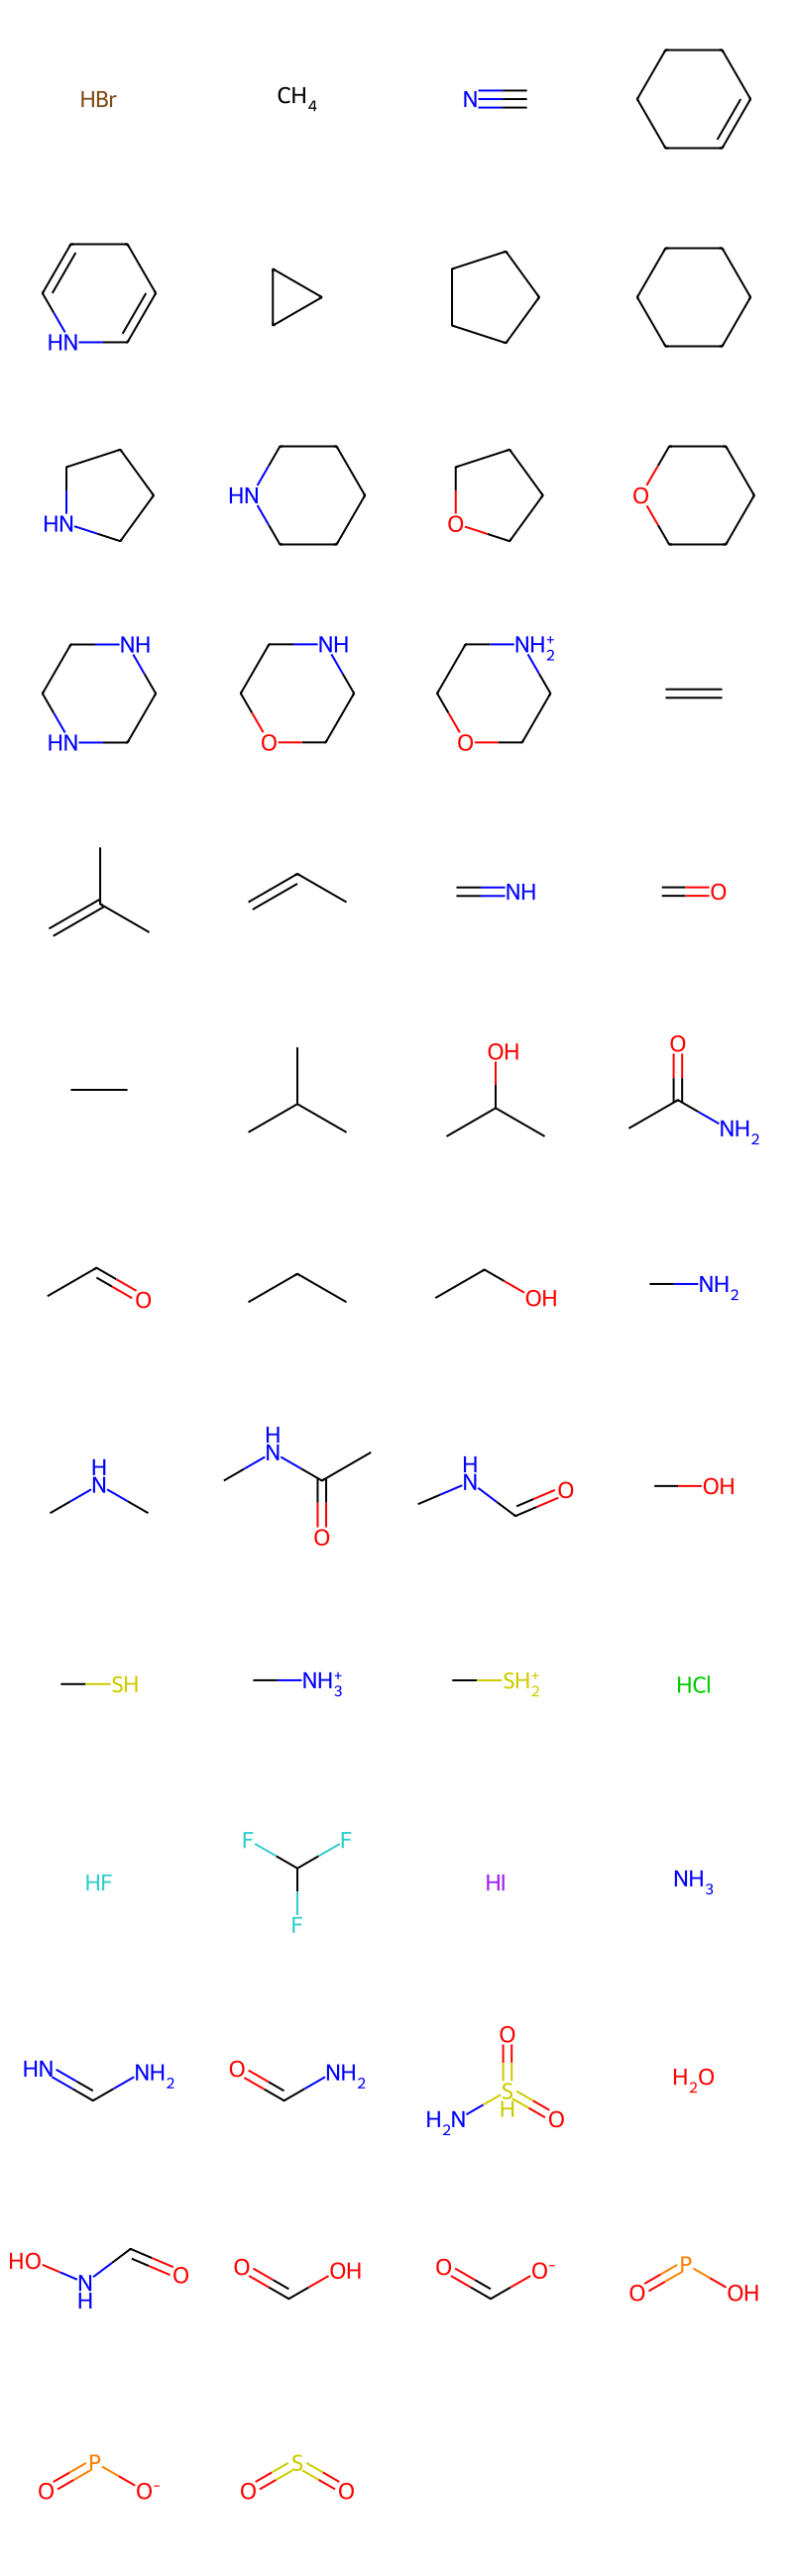

In [44]:
molecules = [Chem.MolFromSmiles(smiles) for smiles, _ in bengio_frag]

img = Draw.MolsToGridImage(molecules, molsPerRow=4, subImgSize=(200, 200))

img



In [45]:
import torch
from gflownet.config import init_empty, Config
from gflownet.models.graph_transformer import GraphTransformerGFN
from gflownet.envs.graph_building_env import GraphBuildingEnv
from gflownet.envs.frag_mol_env import FragMolBuildingEnvContext
from gflownet.envs.mol_building_env import MolBuildingEnvContext #Using this to build graphs didn't work
from gflownet.algo.trajectory_balance import TrajectoryBalance
from gflownet.algo.graph_sampling import GraphSampler

In [46]:
if torch.cuda.is_available():
    print("cuda available")
    from gflownet.utils.misc import set_main_process_device
    dev = torch.device('cuda')
    set_main_process_device(dev)
else:
    print("cpu mode")
    dev = torch.device('cpu')

cpu mode


In [47]:
torch.manual_seed(1)  # For demonstration purposes
cfg = Config()
env = GraphBuildingEnv()
ctx = FragMolBuildingEnvContext(fragments = final_frags)
model = GraphTransformerGFN(ctx, cfg).to(dev)
model2 = GraphTransformerGFN(ctx, cfg).to(dev)
# with open('/content/Without_SA') as file:
#   model = pickle.load(file)
# with open('/content/With_SA') as file:
#   model2 = pickle.load(file)
opt = torch.optim.Adam(model.parameters(), 3e-4)
algo = TrajectoryBalance(env, ctx, cfg)

In [48]:
model.parameters

<bound method Module.parameters of GraphTransformerGFN(
  (transf): GraphTransformer(
    (x2h): Sequential(
      (0): Linear(in_features=73, out_features=128, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=128, out_features=128, bias=True)
    )
    (e2h): Sequential(
      (0): Linear(in_features=14, out_features=128, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=128, out_features=128, bias=True)
    )
    (c2h): Sequential(
      (0): Linear(in_features=1, out_features=128, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=128, out_features=128, bias=True)
    )
   

In [49]:
'''import logging
logger = logging.getLogger()
logger.filter()'''

'import logging\nlogger = logging.getLogger()\nlogger.filter()'

In [50]:
import pickle
import math

In [51]:
'''with open('D:\drug_modelling\Without_SA.unknown', 'rb') as file:
    model = pickle.load(file)
with open('D:\drug_modelling\With_SA','rb') as file:
    model2 = pickle.load(file)'''

"with open('D:\\drug_modelling\\Without_SA.unknown', 'rb') as file:\n    model = pickle.load(file)\nwith open('D:\\drug_modelling\\With_SA','rb') as file:\n    model2 = pickle.load(file)"

In [ ]:
import multiprocessing
from functools import partial

n_processes = multiprocessing.cpu_count() - 4
print("Using {} processes  for parallel evaluation.".format(n_processes))

opt = torch.optim.Adam(model.parameters(), 1e-3) 
opt2 = torch.optim.Adam(model2.parameters(), 3e-4)
try:
    from tqdm.notebook import tqdm
except:
    tdqm = lambda x: x
beta = 32
losses = [] 
avg_rewards = []
avg_sascore = []
avg_pic50 = []
epochs = 100
for i in tqdm(range(epochs)):
    start = time.time()
    with torch.no_grad():  # We don't need to compute gradients here, they will be later
        trajs = algo.create_training_data_from_own_samples(model2, 64)
        objs = [ctx.graph_to_obj(i['result']) for i in trajs]
        
        # Parallel processing starts here
        with multiprocessing.Pool(processes=n_processes) as pool:
            results = pool.map(reward_with_score, objs)
        
        # Unpack results
        full_reward_list, current_pic50, current_sascore = zip(*results)
        full_reward_list = list(full_reward_list)
        avg_pic = sum(current_pic50) / len(current_pic50)
        avg_sa = sum(current_sascore) / len(current_sascore)
        print(f"Iteration {i}: Average PIC = {avg_pic:.4f}, Average SA = {avg_sa:.4f}")
        # Extend metrics
        avg_pic50.extend(current_pic50)
        avg_sascore.extend(current_sascore)

        log_rewards = torch.tensor(full_reward_list).to(dev)
        avg_rewards.append((log_rewards / len(trajs)).mean().item())
    batch = algo.construct_batch(trajs, None, log_rewards).to(dev)
    loss, _ = algo.compute_batch_losses(model2, batch)
    loss.backward()
    opt2.step()
    opt2.zero_grad()

    losses.append(loss.item())
    end = time.time()
    print(start-end)
    if i %10 ==0:
        checkpoint = {
        'epoch': i,
        'model_state_dict': model2.state_dict(),
        'optimizer_state_dict': opt2.state_dict(),
        'loss_history': losses,      
        'reward_history': avg_rewards,
        'pic50_history': avg_pic50,
        'sascore_history': avg_sascore
        }
        torch.save(checkpoint, 'checkpoints/checkpoint_pic50_sascore_bengio_frags.pth')

Using 16 processes  for parallel evaluation.


  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
epochs = 100

In [ ]:
checkpoint = {
    'epoch': epochs,
    'model_state_dict': model2.state_dict(),
    'optimizer_state_dict': opt2.state_dict(),
    'loss_history': losses,      
    'reward_history': avg_rewards
}
torch.save(checkpoint, 'checkpoints/checkpoint_100epochs_pic50_bengio_frags.pth')

In [ ]:
torch.save(model2.state_dict(), 'saved_models/model_state_100epochs_pic50_bengio_frags.pth')

In [ ]:
#print(model2.state_dict())
#print(opt2.state_dict())

In [ ]:
checkpoint = torch.load('checkpoints/checkpoint_100epochs_pic50_bengio_frags.pth', map_location=torch.device('cpu'))
model2.load_state_dict(checkpoint['model_state_dict'])
opt2.load_state_dict(checkpoint['optimizer_state_dict'])
loss_history = checkpoint.get('loss_history', [])
reward_history = checkpoint.get('reward_history', [])

In [ ]:
#print(model2.state_dict())
#print(opt2.state_dict())

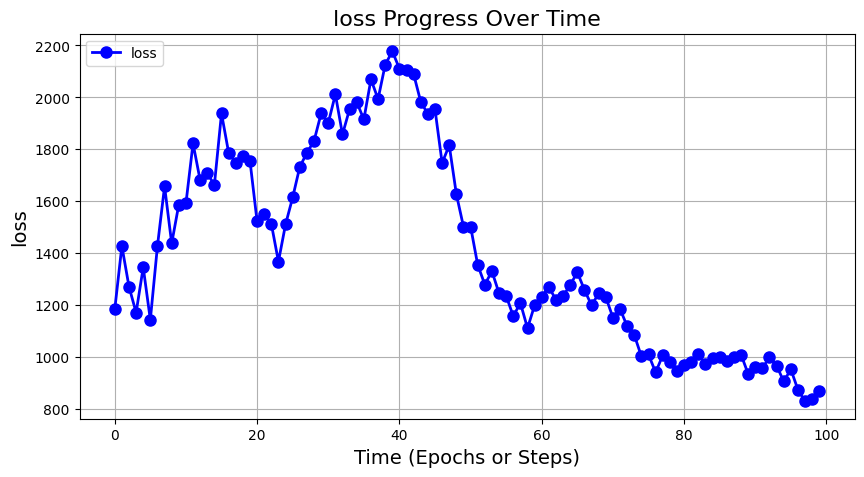

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(losses, marker='o', linestyle='-', color='b', markersize=8, linewidth=2)

# Adding labels and title
plt.xlabel('Time (Epochs or Steps)', fontsize=14)
plt.ylabel('loss', fontsize=14)
plt.title('loss Progress Over Time', fontsize=16)

# Optional: Grid and legend
plt.grid(True)
plt.legend(['loss'], loc='upper left')

# Display the plot
plt.show()

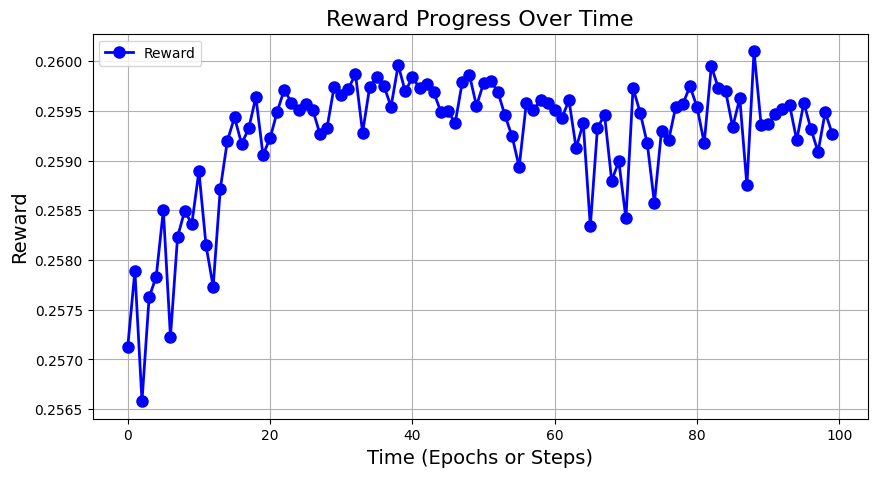

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(avg_rewards, marker='o', linestyle='-', color='b', markersize=8, linewidth=2)

# Adding labels and title
plt.xlabel('Time (Epochs or Steps)', fontsize=14)
plt.ylabel('Reward', fontsize=14)
plt.title('Reward Progress Over Time', fontsize=16)

# Optional: Grid and legend
plt.grid(True)
plt.legend(['Reward'], loc='upper left')

# Display the plot
plt.show()

In [ ]:
'''opt = torch.optim.Adam(model.parameters(), 1e-3)
opt2 = torch.optim.Adam(model2.parameters(), 3e-4)
try:
    from tqdm.notebook import tqdm
except:
    tdqm = lambda x: x
beta = 32
losses2 = []
avg_rewards2 = []
for i in tqdm(range(150)):
    with torch.no_grad():  # We don't need to compute gradients here, they will be later
        trajs = algo.create_training_data_from_own_samples(model2, 64)

        #objs = [ctx.graph_to_obj(i['result']) for i in trajs] gives problems with the bigger dataset

        objs = []
        valid_trajs=[]
        for traj in trajs:
            try:
                mol = ctx.graph_to_obj(traj['result'])
                Chem.SanitizeMol(mol)  # Validate the molecule
                objs.append(mol)
                valid_trajs.append(traj)
            except Chem.AtomValenceException:
                print(f"Valence issue in: {traj['result']}")
            except Chem.KekulizeException:
                print(f"Kekulization issue in: {traj['result']}")
            except Exception as e:
                print(f"Error: {e}")

        log_rewards = torch.tensor([reward_with_score(x)[0] for x in objs]).to(dev)
    avg_rewards2.append((log_rewards / beta).mean().item())
    trajs = valid_trajs
    batch = algo.construct_batch(trajs, None, log_rewards).to(dev)
    loss, _ = algo.compute_batch_losses(model2, batch)
    loss.backward()
    opt2.step()
    opt2.zero_grad()

    losses2.append(loss.item())'''
    

In [ ]:
print(losses)

In [ ]:
print(avg_rewards)

In [ ]:
'''opt = torch.optim.Adam(model.parameters(), 1e-3)
opt2 = torch.optim.Adam(model2.parameters(), 3e-4)
try:
    from tqdm.notebook import tqdm
except:
    tdqm = lambda x: x
beta = 32
losses2 = []
avg_rewards2 = []
for i in tqdm(range(500)):
    with torch.no_grad():  # We don't need to compute gradients here, they will be later
        trajs = algo.create_training_data_from_own_samples(model, 64)

        #objs = [ctx.graph_to_obj(i['result']) for i in trajs]

        objs = []
        valid_trajs=[]
        for traj in trajs:
            try:
                mol = ctx.graph_to_obj(traj['result'])
                Chem.SanitizeMol(mol)  # Validate the molecule
                objs.append(mol)
                valid_trajs.append(traj)
            except Chem.AtomValenceException:
                print(f"Valence issue in: {traj['result']}")
            except Chem.KekulizeException:
                print(f"Kekulization issue in: {traj['result']}")
            except Exception as e:
                print(f"Error: {e}")
        log_rewards = torch.tensor([reward(x) for x in objs]).to(dev)
    trajs = valid_trajs
    batch = algo.construct_batch(trajs, None, log_rewards).to(dev)
    loss, _ = algo.compute_batch_losses(model, batch)
    loss.backward()
    opt.step()
    opt.zero_grad()

    losses2.append(loss.item())
    avg_rewards2.append((log_rewards / beta).exp().mean().item())'''

In [ ]:
print(avg_rewards2)
print(losses2)

1) reduce beta to low value while sampling.  

In [ ]:
'''for x in _:
  print(sascorer.calculateScore(x))'''

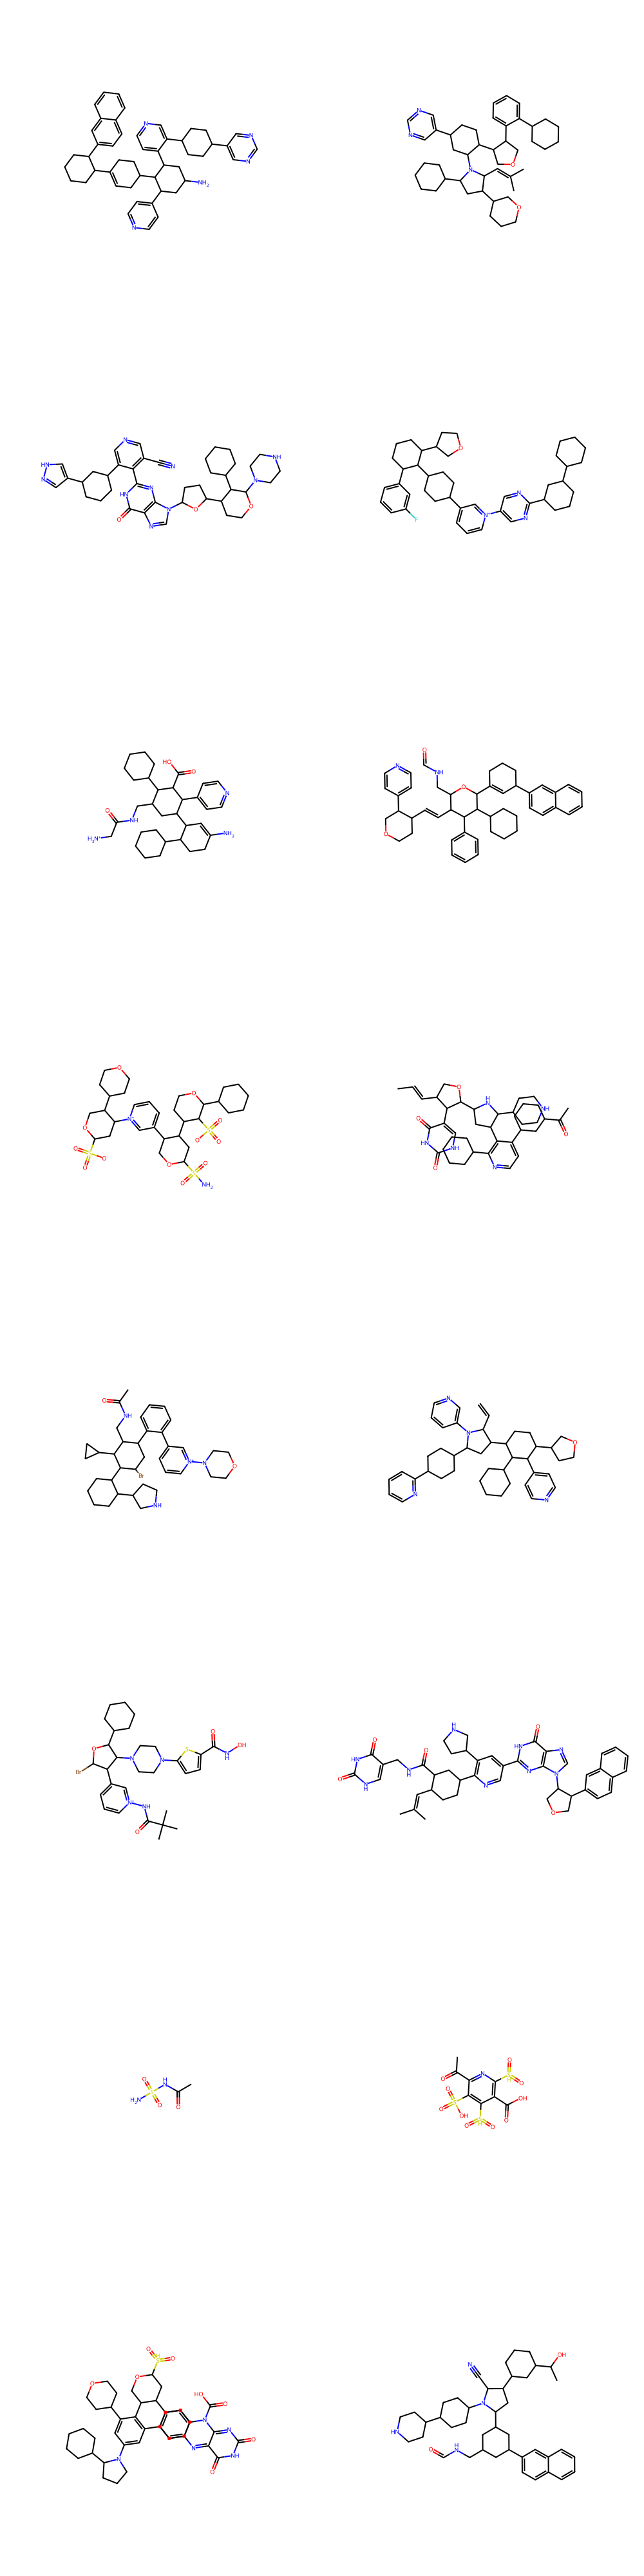

In [ ]:
gensmiles,genmoles,im = test_model(model = model2,mols_per_row=2)
im


In [ ]:

avg_wt = []
avg_sa = []
avg_mic = []

for i in genmoles:
    print("molecule number, ", i)
    x = reward_with_score(i)
    avg_wt.append(x[2])
    avg_sa.append(x[1])
    avg_mic.append(x[3])
print("average sa score", np.average(avg_sa))
print("average weight", np.average(avg_wt))
print("averge mic", np.average(avg_mic))

sns.histplot(avg_sa, bins=8, kde=False)  # kde=True adds a density curve
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Sa score')
plt.show()

sns.histplot(avg_wt, bins=8, kde=False)  # kde=True adds a density curve
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Weight')
plt.show()

sns.histplot(avg_mic, bins=8, kde=False)  # kde=True adds a density curve
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('MIC')
plt.show()

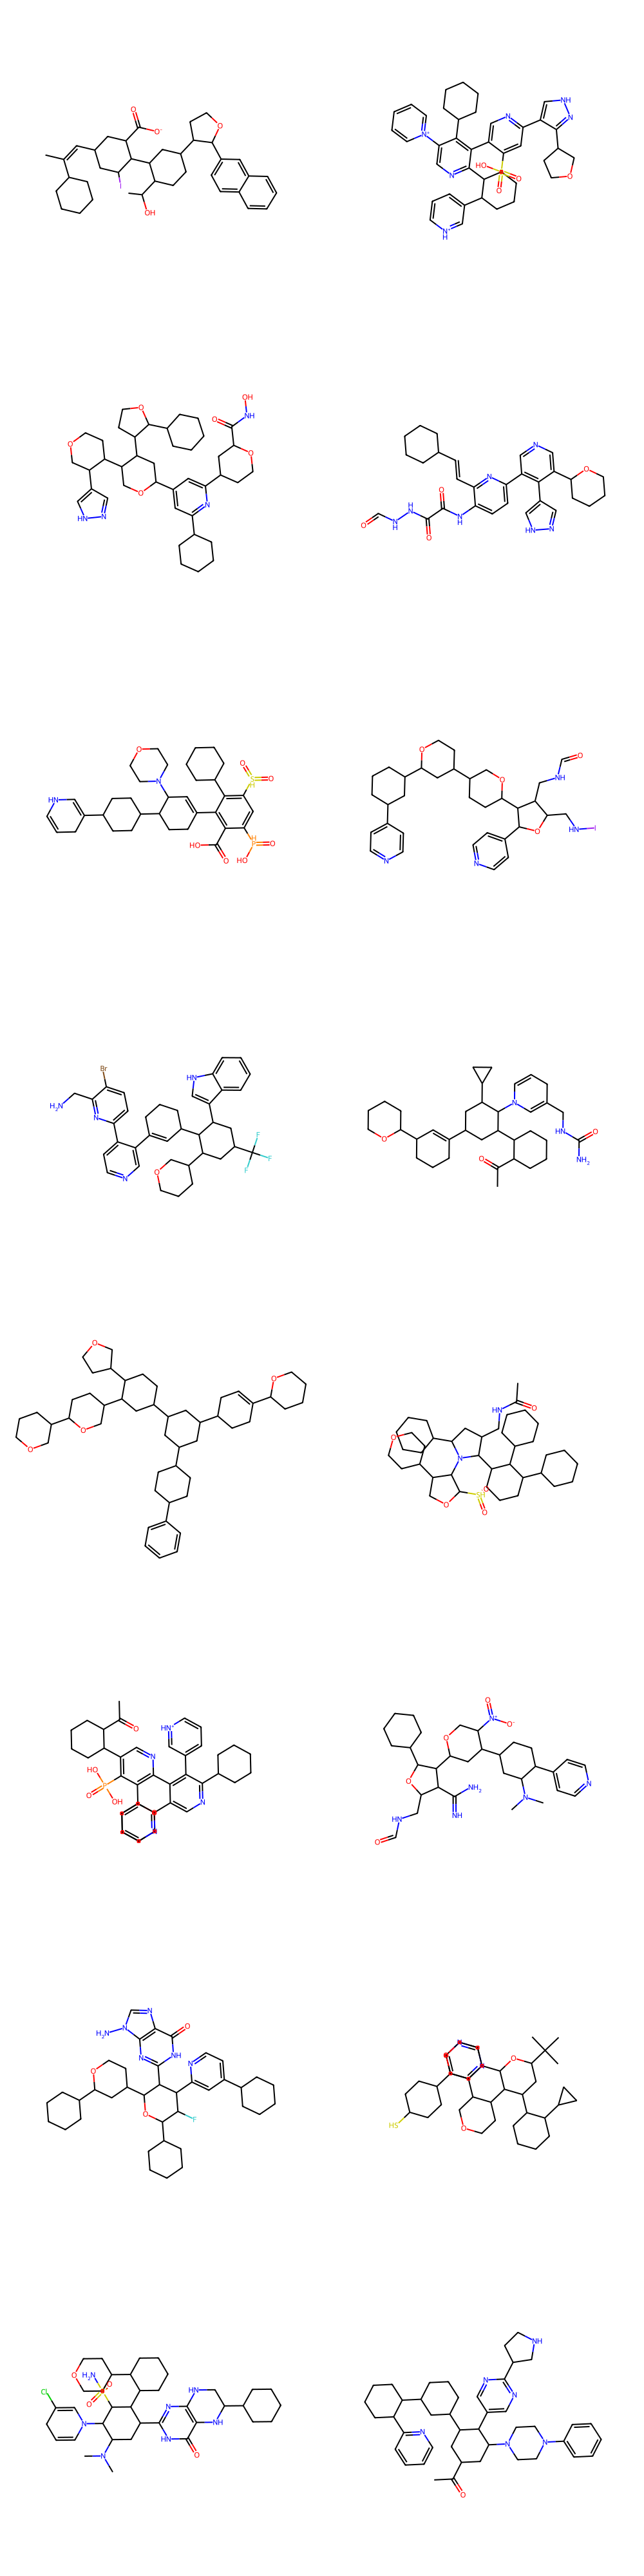

In [ ]:
gensmiles2,genmoles2,im2 = test_model(model = model2,mols_per_row=2)
im2


In [ ]:
for i in genmoles2:
    print("molecule number, ", i)
    reward_with_score(i)

molecule number,  <rdkit.Chem.rdchem.Mol object at 0x00000227048FECE0>
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1


100%|██████████| 1/1 [00:04<00:00,  4.24s/it]


Saving predictions to /dev/null
Elapsed time = 0:00:04
mic estimate 5.994356603493329
primary reward, 16.682357526364555
molecule number,  <rdkit.Chem.rdchem.Mol object at 0x00000227048FED50>
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1


100%|██████████| 1/1 [00:04<00:00,  4.10s/it]


Saving predictions to /dev/null
Elapsed time = 0:00:04
mic estimate 6.151039649847737
primary reward, 16.25741430596621
molecule number,  <rdkit.Chem.rdchem.Mol object at 0x00000227048FEDC0>
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1


100%|██████████| 1/1 [00:04<00:00,  4.04s/it]


Saving predictions to /dev/null
Elapsed time = 0:00:04
mic estimate 6.138892009218824
primary reward, 16.28958448036375
molecule number,  <rdkit.Chem.rdchem.Mol object at 0x00000227048FEE30>
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1


100%|██████████| 1/1 [00:04<00:00,  4.18s/it]


Saving predictions to /dev/null
Elapsed time = 0:00:04
mic estimate 6.0356889060079855
primary reward, 16.56811700491372
molecule number,  <rdkit.Chem.rdchem.Mol object at 0x00000227048FEEA0>
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1


100%|██████████| 1/1 [00:04<00:00,  4.07s/it]


Saving predictions to /dev/null
Elapsed time = 0:00:04
mic estimate 6.089365346716788
primary reward, 16.42207263092157
molecule number,  <rdkit.Chem.rdchem.Mol object at 0x00000227048FEF10>
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1


100%|██████████| 1/1 [00:03<00:00,  3.97s/it]


Saving predictions to /dev/null
Elapsed time = 0:00:04
mic estimate 6.007016397734025
primary reward, 16.647199437930972
molecule number,  <rdkit.Chem.rdchem.Mol object at 0x00000227048FEF80>
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1


100%|██████████| 1/1 [00:06<00:00,  6.48s/it]


Saving predictions to /dev/null
Elapsed time = 0:00:06
mic estimate 6.011246770674669
primary reward, 16.635484087567505
molecule number,  <rdkit.Chem.rdchem.Mol object at 0x00000227048FEFF0>
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1


100%|██████████| 1/1 [00:05<00:00,  5.84s/it]


Saving predictions to /dev/null
Elapsed time = 0:00:06
mic estimate 5.982060895678455
primary reward, 16.716646945577192
molecule number,  <rdkit.Chem.rdchem.Mol object at 0x00000227048FF060>
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1


100%|██████████| 1/1 [00:05<00:00,  5.11s/it]


Saving predictions to /dev/null
Elapsed time = 0:00:05
mic estimate 6.078105213946925
primary reward, 16.45249571701034
molecule number,  <rdkit.Chem.rdchem.Mol object at 0x00000227048FF0D0>
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1


100%|██████████| 1/1 [00:05<00:00,  5.14s/it]


Saving predictions to /dev/null
Elapsed time = 0:00:05
mic estimate 6.062873624567169
primary reward, 16.493828866033642
molecule number,  <rdkit.Chem.rdchem.Mol object at 0x00000227048FF140>
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1


100%|██████████| 1/1 [00:04<00:00,  4.88s/it]


Saving predictions to /dev/null
Elapsed time = 0:00:05
mic estimate 6.0815377034420415
primary reward, 16.443209740096126
molecule number,  <rdkit.Chem.rdchem.Mol object at 0x00000227048FF1B0>
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1


100%|██████████| 1/1 [00:05<00:00,  5.17s/it]


Saving predictions to /dev/null
Elapsed time = 0:00:05
mic estimate 6.014348503719058
primary reward, 16.626904799108928
molecule number,  <rdkit.Chem.rdchem.Mol object at 0x00000227048FF220>
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1


100%|██████████| 1/1 [00:04<00:00,  4.70s/it]


Saving predictions to /dev/null
Elapsed time = 0:00:05
mic estimate 6.089513711067795
primary reward, 16.421672525057016
molecule number,  <rdkit.Chem.rdchem.Mol object at 0x00000227048FF290>
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1


100%|██████████| 1/1 [00:05<00:00,  5.10s/it]


Saving predictions to /dev/null
Elapsed time = 0:00:05
mic estimate 6.09440888453331
primary reward, 16.408482248997913
molecule number,  <rdkit.Chem.rdchem.Mol object at 0x00000227048FF300>
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1


100%|██████████| 1/1 [00:05<00:00,  5.01s/it]


Saving predictions to /dev/null
Elapsed time = 0:00:05
mic estimate 6.143931627466011
primary reward, 16.27622279404235
molecule number,  <rdkit.Chem.rdchem.Mol object at 0x00000227048FF370>
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1


100%|██████████| 1/1 [00:05<00:00,  5.35s/it]

Saving predictions to /dev/null
Elapsed time = 0:00:05
mic estimate 6.01304059195606
primary reward, 16.63052135948906


In [ ]:
from rdkit.Chem import SDMolSupplier

# Initialize an empty list to store the molecules
molecule_list = []

# Read the molecules from the SDF file
supplier = SDMolSupplier(".\\generated\\generated_molecules_small_frags_rachana_100epochs.sdf")

# Iterate through the molecules and add them to the list if they are valid
for mol in supplier:
    if mol is not None:  # Ensure molecule is valid
        molecule_list.append(mol)

# Check the first few molecules to confirm
print(f"Number of molecules read: {len(molecule_list)}")
print(molecule_list[:5])  # Display the first 5 molecules in the list


for i in molecule_list:
    print("molecule number, ", i)
    reward_with_score(i)


In [ ]:
# Read SMILES strings from a text file
with open('D:\drug_modelling\generated\generated_smiles2_bengio_frags_pic50_100epochs.txt', 'r') as file:
    smiles_list = [line.strip() for line in file if line.strip()]


In [ ]:
from rdkit import Chem

# Convert SMILES to molecule objects and calculate SA scores
molecules = []
sa_scores = []
for smiles in smiles_list:
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        molecules.append(mol)
        sa_score = sascorer.calculateScore(mol)
        sa_scores.append(sa_score)
    else:
        print(f"Invalid SMILES: {smiles}")


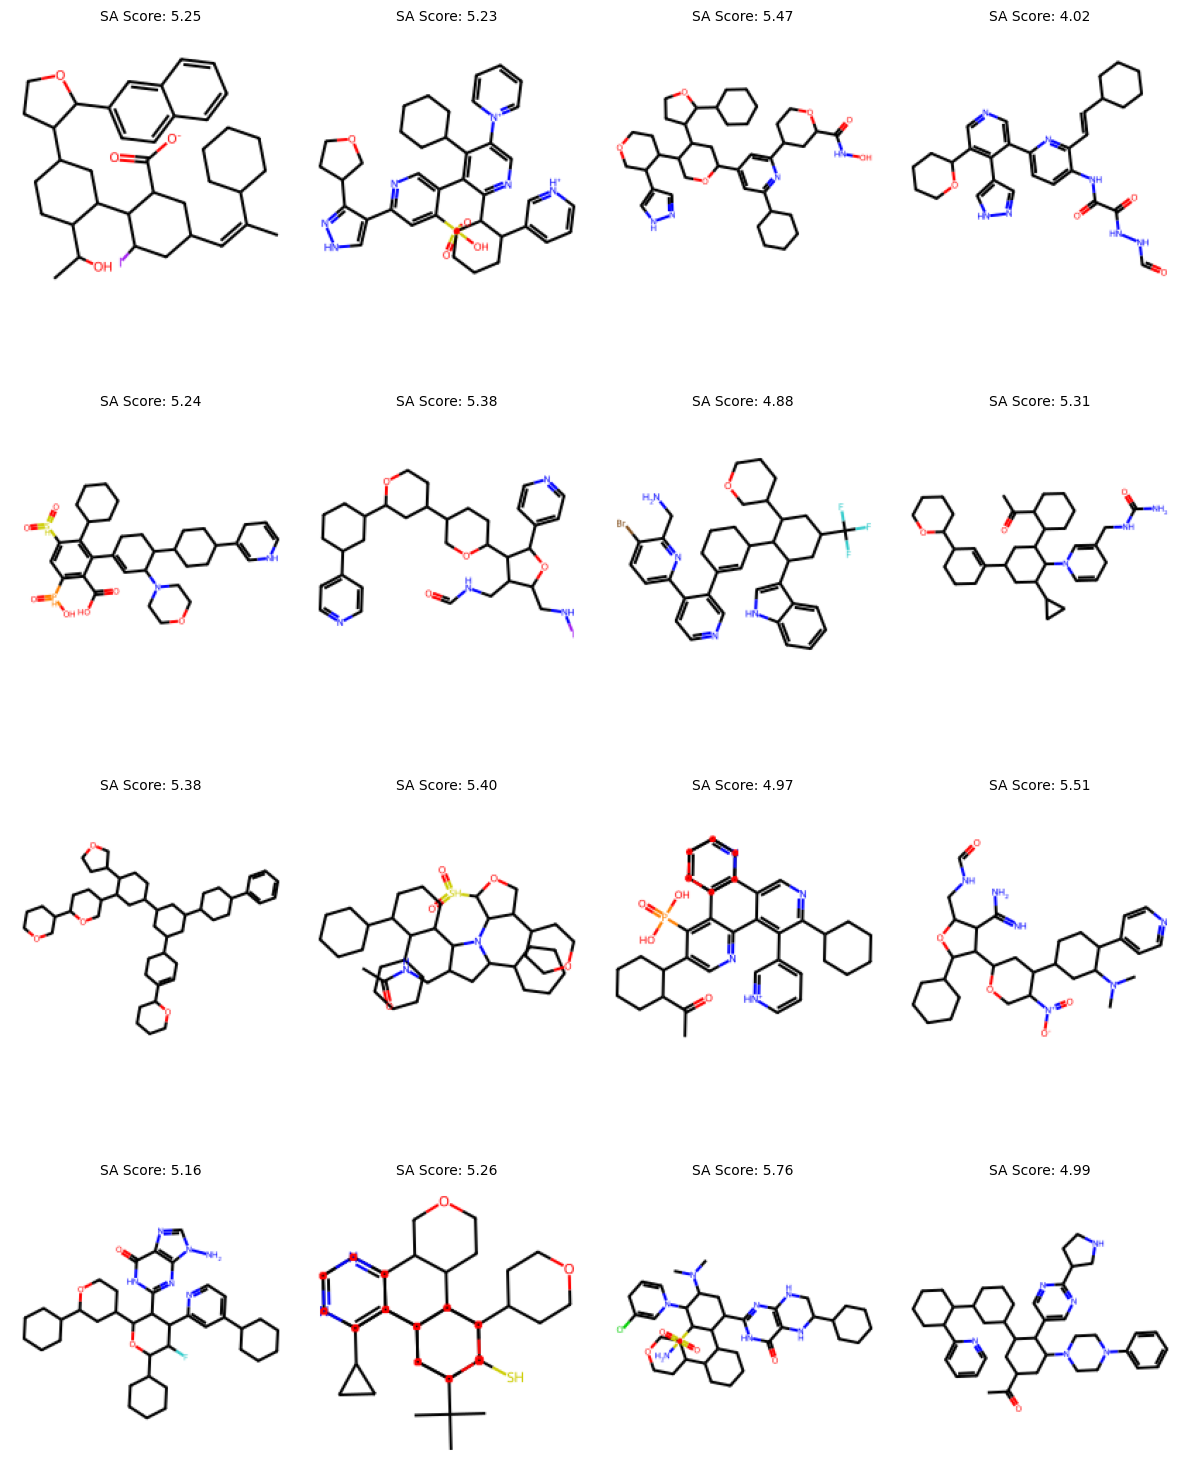

In [ ]:
import matplotlib.pyplot as plt
from rdkit.Chem import Draw

# Define grid size
mols_per_row = 4
sub_img_size = (200, 200)
n_rows = (len(molecules) + mols_per_row - 1) // mols_per_row

# Create a figure
fig, axes = plt.subplots(n_rows, mols_per_row, figsize=(mols_per_row * 3, n_rows * 4))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, (mol, sa_score) in enumerate(zip(molecules, sa_scores)):
    # Draw molecule
    img = Draw.MolToImage(mol, size=sub_img_size)
    axes[i].imshow(img)
    axes[i].axis('off')
    # Display SA score
    axes[i].set_title(f'SA Score: {sa_score:.2f}', fontsize=10)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
with open(".\generated\generated_molecules2_bengio_frags_pic50_100epochs.txt", "w") as f:
    for smile in gensmiles:
        f.write(smile + "\n")
from rdkit.Chem import SDWriter

with SDWriter(".\generated\generated_molecules_bengio_frags_pic50_100epochs.sdf") as writer:
    for mol in genmoles:
        if mol is not None:  # Ensure molecule is valid
            writer.write(mol)

with open(".\generated\generated_molecules_bengio_frags_pic50_100epochs.png", "wb") as f:
    f.write(im.data)

In [ ]:
with open(".\generated\generated_smiles2_bengio_frags_pic50_100epochs.txt", "w") as f:
    for smile in gensmiles2:
        f.write(smile + "\n")
from rdkit.Chem import SDWriter

with SDWriter(".\generated\generated_molecules2_bengio_frags_pic50_100epochs.sdf") as writer:
    for mol in genmoles2:
        if mol is not None:  # Ensure molecule is valid
            writer.write(mol)

with open(".\generated\generated_images2_bengio_frags_pic50_100epochs.png", "wb") as f:
    f.write(im2.data)